# Sentiment analysis: IMDB reviews

## About this notebook

This notebook allows you to classify movie reviews extracted from the [IMBD](https://www.imdb.com/) website. By means of embeddings, it also allows you to visualize how the different words cluster with each other.

![](img/embedding.png)

## Sentiment Analysis

Sentiment analysis is a *Natural Language Processing* technique used to determine the "sentiment" of a corpus of text (e.g., whether the opinion expressed is either positive or negative).

The model presented in this notebook, provides the following accuracies:

- Train accuracy: 99.03%
- Test accuracy: 84.27%

## Data

The dataset used to train the present model, correpsond to the [IMDB reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews) dataset. 
It is composed by:

- Training set: 25,000 examples.
- Test set: 25,000 examples. 

![](img/wordcloud.png)


## Imports

In [1]:
# General imports
import numpy as np ; np.random.seed(1) # for reproducibility
import os
import joblib
import io
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import random
import shutil
from datetime import datetime
from sklearn.model_selection import train_test_split
import platform
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# TensorFlow
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorboard.plugins import projector


## TensorFlow information

In [2]:
# Indicate the version of Tensorflow and whether it uses the CPU or the GPU
print("TensorFlow version:", tf.__version__)

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("The GPU will be used for calculations.")
    
else:
    print("The CPU will be used for calculations.")

TensorFlow version: 2.4.0
The CPU will be used for calculations.


## Folders

In [3]:
# Define paths
path_data = './data'
path_model = './model'
path_output = './output'

## 1. Import data 

In [4]:
# Download data
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# Split train and test data
train_data, test_data = imdb['train'], imdb['test']

# Initialize datasets
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Extract sentences and labels from the training data
for s,l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

# Transform to numpy arrays
training_sentences = np.array(training_sentences)
testing_sentences = np.array(testing_sentences)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

# Save data
joblib.dump(training_labels, os.path.join(path_data, 'training_labels'))
joblib.dump(testing_labels, os.path.join(path_data, 'testing_labels'))
joblib.dump(training_sentences, os.path.join(path_data, 'training_sentences'))
joblib.dump(testing_sentences, os.path.join(path_data, 'testing_sentences'))


['./data/testing_sentences']

In [8]:
# Load data
training_labels = joblib.load(os.path.join(path_data, 'training_labels'))
testing_labels = joblib.load(os.path.join(path_data, 'testing_labels'))
training_sentences = joblib.load(os.path.join(path_data, 'training_sentences'))
testing_sentences = joblib.load(os.path.join(path_data, 'testing_sentences'))


## 2. Tokenize the data

In [9]:
# Define hyper-parameters
vocab_size = 20000
embedding_dim = 32
max_length = 240
trunc_type='post'
oov_tok = "<OOV>"

# Tokenize the words in the sentences
tokenizer = Tokenizer(
    num_words = vocab_size, 
    oov_token = oov_tok
)

# Update internal vocabulary based on list of texts
tokenizer.fit_on_texts(training_sentences)

# Generate index of words
word_index = tokenizer.word_index

# Tokenize training sentences
training_sequences = tokenizer.texts_to_sequences(training_sentences)

# Add padding
training_padded = pad_sequences(
    training_sequences,
    maxlen = max_length, 
    truncating = trunc_type
)

# Repeat for test data
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(
    testing_sequences,
    maxlen = max_length,
)

## 3. Describe data

In [10]:
# Describe the data
print("\nDictionary length =", len(word_index))
print("\nNumber of training instances =" , training_padded.shape[0])
print("Number of testing instances =" , testing_padded.shape[0])
print("\nTraining instance max length =" , training_padded.shape[1])
print("Testing instance max length =" , testing_padded.shape[1])
print("\n- First instance:\n")
print(training_sentences[0])
print("\n- Padded sequence for the first instance:\n")
print(training_padded[0])
print("\n- Label for the first instance:\n")
if training_labels[0] == 0:
    print("0: BAD review\n")
else:
    print("1: GOOD review\n")


Dictionary length = 86539

Number of training instances = 25000
Number of testing instances = 25000

Training instance max length = 240
Testing instance max length = 240

- First instance:

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

- Padded sequence for the first instance:

[    0     0     0     0     0     0     0     0    

## 4. Data Preprocessing

### Shuffle data

In [11]:
# Transform to numpy arrays
training_sequences = np.array(training_sequences, dtype="object")
testing_sequences = np.array(testing_sequences, dtype="object")

# Shuffle train data
permut = np.random.permutation(training_padded.shape[0])
training_sentences = training_sentences[permut]
training_labels = training_labels[permut]
training_sequences = training_sequences[permut]
training_padded = training_padded[permut]

# Shuffle test data
permut = np.random.permutation(testing_padded.shape[0])
testing_sentences = testing_sentences[permut]
testing_labels = testing_labels[permut]
testing_sequences = testing_sequences[permut]
testing_padded = testing_padded[permut]

### Create validation set

In [9]:
# Create validation set
train_padded, validation_padded, train_labels, validation_labels = train_test_split(
    training_padded, 
    training_labels, 
    test_size=0.05, 
    random_state=42
)

In [10]:
# Describe data dimensions
print('\nTraining dimensions:', train_padded.shape)
print('Training labels size:', train_labels.shape[0])
print('\nValidation dimensions:', validation_padded.shape)
print('Validation labels size:', validation_labels.shape[0])
print('\nTest dimensions:', testing_padded.shape)
print('Test labels size:', testing_labels.shape[0])


Training dimensions: (23750, 240)
Training labels size: 23750

Validation dimensions: (1250, 240)
Validation labels size: 1250

Test dimensions: (25000, 240)
Test labels size: 25000


## 5. Convolutional NN


### Model

In [11]:
# Create CNN architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 240, 32)           640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 657,037
Trainable params: 657,037
Non-trainable params: 0
_________________________________________________________________


### Compile

In [12]:
# Compile model
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

## 6. Train

In [13]:
# Set seed for random functions
tf.random.set_seed(1)

# Fit the model 
history = model.fit(
    x=train_padded,
    y=train_labels,
    batch_size=32,
    epochs=10,
    verbose=2,
    validation_data=(validation_padded, validation_labels)
)

# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history

# Save model and history
model.save(os.path.join(path_model, 'imdb_model.h5'))
model.save_weights(os.path.join(path_model, 'imdb_weights.h5'))
joblib.dump(history_dict, os.path.join(path_model, 'imdb_history'))
    

Epoch 1/10
743/743 - 48s - loss: 0.4822 - accuracy: 0.7725 - val_loss: 0.3168 - val_accuracy: 0.8648
Epoch 2/10
743/743 - 48s - loss: 0.2725 - accuracy: 0.9002 - val_loss: 0.3380 - val_accuracy: 0.8696
Epoch 3/10
743/743 - 51s - loss: 0.1894 - accuracy: 0.9338 - val_loss: 0.3800 - val_accuracy: 0.8424
Epoch 4/10
743/743 - 48s - loss: 0.1477 - accuracy: 0.9480 - val_loss: 0.4580 - val_accuracy: 0.7912
Epoch 5/10
743/743 - 48s - loss: 0.1363 - accuracy: 0.9527 - val_loss: 0.4864 - val_accuracy: 0.8592
Epoch 6/10
743/743 - 50s - loss: 0.0940 - accuracy: 0.9689 - val_loss: 0.5254 - val_accuracy: 0.8656
Epoch 7/10
743/743 - 52s - loss: 0.1290 - accuracy: 0.9491 - val_loss: 0.4962 - val_accuracy: 0.8712
Epoch 8/10
743/743 - 47s - loss: 0.0933 - accuracy: 0.9674 - val_loss: 0.5186 - val_accuracy: 0.8480
Epoch 9/10
743/743 - 55s - loss: 0.0485 - accuracy: 0.9842 - val_loss: 0.7068 - val_accuracy: 0.8504
Epoch 10/10
743/743 - 51s - loss: 0.0496 - accuracy: 0.9832 - val_loss: 0.9210 - val_accura

['./model/imdb_history']

In [5]:
# Load model and history
model = keras.models.load_model(os.path.join(path_model, 'imdb_model.h5'))
model.load_weights(os.path.join(path_model, 'imdb_weights.h5'))
history_dict = joblib.load(os.path.join(path_model, 'imdb_history'))

## 7. Accuracy and Loss for the Model

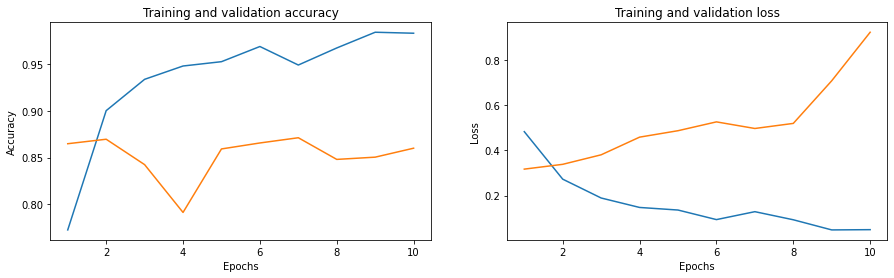

In [6]:
# Get metrics on training and test data
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Get number of epochs
epochs = range(1, len(acc)+1) 

# Set up plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4));

# Plot training and validation accuracy per epoch
ax1.plot(epochs, acc, label='Training accuracy');
ax1.plot(epochs, val_acc, label='Validation accuracy');
ax1.set_title('Training and validation accuracy');
ax1.set(xlabel='Epochs', ylabel='Accuracy');

# Plot training and validation loss per epoch
ax2.plot(epochs, loss, label='Training loss');
ax2.plot(epochs, val_loss, label='Validation loss');
ax2.set_title('Training and validation loss');
ax2.set(xlabel='Epochs', ylabel='Loss');

# Save plot
plt.savefig('app/assets/acc.png', dpi=600, facecolor='w', edgecolor='w',);

## 8. Predict

In [12]:
# Evaluate final accuracy of the model
train_scores = model.evaluate(training_padded, training_labels, verbose=0)
print("- Train accuracy: " + str(round(train_scores[1]*100, 2)) + '%')
test_scores = model.evaluate(testing_padded, testing_labels, verbose=0)
print("- Test accuracy: " + str(round(test_scores[1]*100, 2)) + '%')

Train accuracy: 99.03%
Test accuracy: 84.27%


In [13]:
# Print 5 test examples
test_set = testing_sentences[0:5]

# Tokenize
sequences = tokenizer.texts_to_sequences(test_set)

# Add padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

# Predict
predictions = model.predict(padded)

# Print results
for i in range(len(test_set)):
    print(test_set[i])
    if testing_labels[i] == 0:
        print("This is a BAD review")
    else:
        print("This is a GOOD review")
    if predictions[i] < 0.5:
        print("Prediction: BAD review\n")
    else:
        print("Prediction: GOOD review\n")


b"Reeves plays Haji Murad, a hero in 1850's Russia.<br /><br />This is a badly dubbed movie, with June Foray doing some of the voices. Unfortunately who ever was suppose to sync the voices to the lips was blind since the words never match the lip flaps. Anyone who says that Japanese films are bad have never watched this film.<br /><br />The film's plot is instantly forgettable and so I've forgotten it in the time its taken the movie to end and for me to sit and write this down. Perhaps it has more to do with the fact that the film is one of the many that Reeves made in hopes of moving away from action to more plot driven sort of films. It may have been a good thing for Reeves, but its deadly for the audience who have to slug through nooze fests such as this, where its all court intrigue with very little action.<br /><br />In Reeves defense, he was a good actor, he just had no real luck in picking films that were any good. They all looked great, but very few of them didn't put the those

## 9. Use case

In [14]:
# Create new instances
list_sentences = [
    "What a great movie", 
    "This show is garbage",
    "The best I've ever seen",
    "Awesome performance",
    "An incredible and remarkable disaster",
    "Incredible show"
]

# Tokenize
sequences = tokenizer.texts_to_sequences(list_sentences)

# Add padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

# Predict
predictions = model.predict(padded)

# Print results
for i in range(len(list_sentences)):
    print(list_sentences[i])
    if predictions[i] < 0.5:
        print("Prediction: BAD review\n")
    else:
        print("Prediction: GOOD review\n")

What a great movie
Prediction: GOOD review

This show is garbage
Prediction: BAD review

The best I've ever seen
Prediction: GOOD review

Awesome performance
Prediction: GOOD review

An incredible and remarkable disaster
Prediction: BAD review

Incredible show
Prediction: GOOD review



## 10. Embeddings

In [19]:
# Embedding shape
embedding = model.layers[0]
weights = embedding.get_weights()[0] 
print('Embedding shape:', weights.shape) 

Embedding shape: (20000, 32)


In [26]:
# Revert dictionary
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Save vectors and labels
out_v = io.open(os.path.join(path_output, 'vectors.tsv'), 'w', encoding='utf-8')
out_m = io.open(os.path.join(path_output, 'metadata.tsv'), 'w', encoding='utf-8')
labels = []
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    labels.append(word)
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

We can visualize the emebddings in this Tensorflow's [page](https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/Guille1899/6185a0ed9d82bf371a984cf7c2ec8547/raw/688afac9a363f872036640cf6e8ddf2fa036c576/config.json).

In [21]:
%%html
<iframe src="https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/Guille1899/6185a0ed9d82bf371a984cf7c2ec8547/raw/688afac9a363f872036640cf6e8ddf2fa036c576/config.json" width="1100" height="600"></iframe>

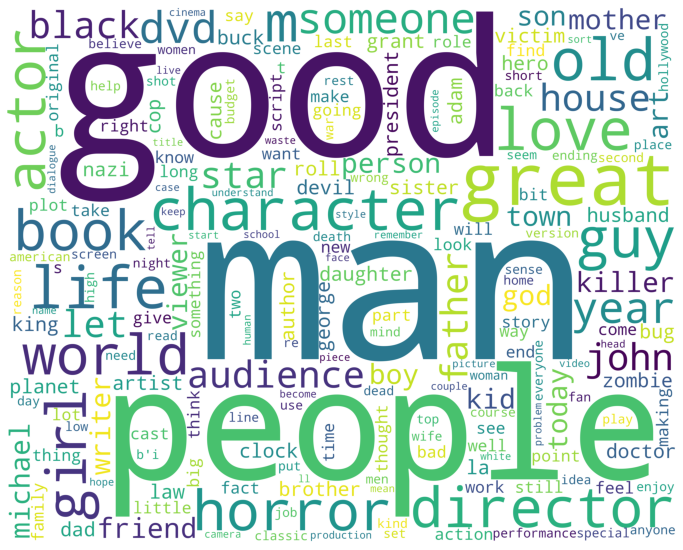

In [39]:
# Remove irrelevant words
stopwords = set(STOPWORDS)
stopwords.update(["one", "film", "movie", "show"])

# Iterate over each label
comment_words = ' '
for val in labels: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    for words in tokens: 
        comment_words = comment_words + words + ' '

# Create wordcloud
wordcloud = WordCloud(width = 5000, height = 4000, 
                background_color = 'white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

# Plot wordcloud
plt.figure(figsize = (12, 12));
plt.imshow(wordcloud);
plt.axis("off");
plt.show();

# Save image
wordcloud.to_file('img/wordcloud.png');
wordcloud.to_file('app/assets/wordcloud.png');